In [335]:
# 基于py3.10
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_sample_weight,compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn import  metrics
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import regularizers
from keras import backend as K
from tensorflow.python.framework.ops import disable_eager_execution
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from imblearn.over_sampling import SMOTE
import numpy.linalg as la
import random

In [252]:
# 导入数据
data = pd.read_csv(r"D:/Code_Project/fc_Project/data.csv",encoding="gbk")

In [253]:
# 观察数据
data

,个人编码,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,3.521200e+14,0,6,7,5.666667,3,2.166667,34,7,5.666667,...,0.939194,4.262371e-03,0.050817,0.0,0.007434,0.0,0,0,1,0
1,3.521200e+14,0,6,4,2.500000,2,1.333333,15,4,2.500000,...,0.955626,2.981609e-03,0.030815,0.0,0.013398,0.0,0,0,1,0
2,3.521200e+14,8,6,8,6.166667,3,2.166667,45,9,7.500000,...,0.783610,3.321330e-04,0.000000,0.0,0.195087,0.0,0,0,0,0
3,3.521200e+14,0,6,6,3.666667,2,1.833333,23,6,3.833333,...,0.458649,1.843500e-04,0.000000,0.0,0.541351,0.0,0,0,0,0
4,3.521200e+14,0,6,5,4.333333,1,1.000000,26,5,4.333333,...,0.983726,3.163870e-04,0.000000,0.0,0.016274,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,3.521280e+14,0,6,8,6.500000,3,3.000000,40,8,6.666667,...,0.986674,5.260850e-04,0.000000,0.0,0.013326,0.0,0,0,1,0
15996,3.521280e+14,0,6,8,6.833333,2,2.000000,42,9,7.000000,...,0.927005,6.890000e-05,0.008665,0.0,0.039553,0.0,1,0,0,0
15997,3.521280e+14,4,6,8,6.333333,2,2.000000,42,9,7.000000,...,0.773433,6.738972e-03,0.002232,1.0,0.223888,0.0,0,0,1,0
15998,3.521280e+14,0,6,5,3.333333,1,1.000000,20,5,3.333333,...,0.967045,7.680000e-07,0.025627,0.0,0.006425,0.0,0,0,0,0


In [254]:
# 删除脱敏且没有意义的列
Desensitized_meaningless_list = [
    '个人编码',
    '顺序号_NN',
    '交易时间DD_NN',
    '交易时间YYYY_NN',
    '交易时间YYYYMM_NN',
]
data = data.drop(Desensitized_meaningless_list,axis=1)

In [255]:
data.isnull().sum()
# 观察到存在缺失值的列,进行缺失值处理

一天去两家医院的天数    0
就诊的月数         0
月就诊天数_MAX     0
月就诊天数_AVG     0
月就诊医院数_MAX    0
             ..
个人支付治疗费用占比    0
BZ_民政救助       0
BZ_城乡优抚       0
是否挂号          0
RES           0
Length: 77, dtype: int64

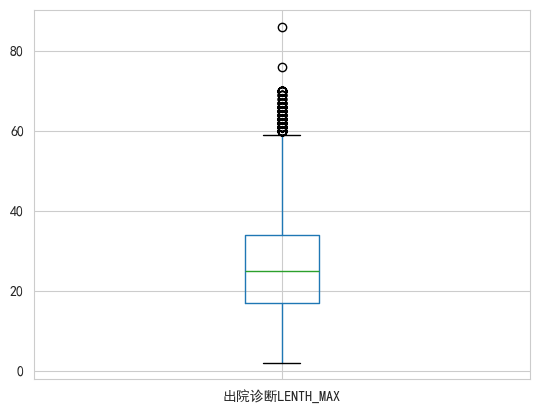

In [256]:
# 缺失值填充
emp_col = '出院诊断LENTH_MAX'
#  先观察箱图
data.boxplot(column=emp_col)
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.show()

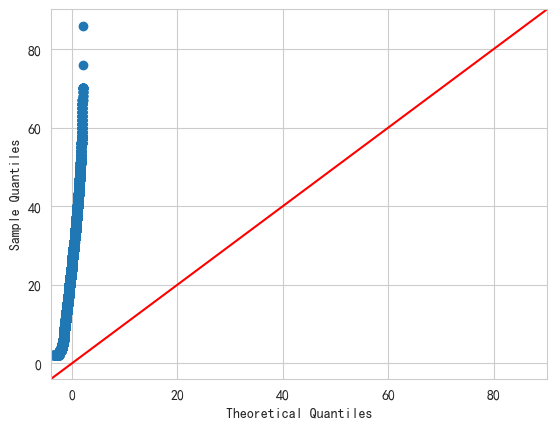

In [257]:
# 观察qq图
sm.qqplot(data[emp_col],line='45')
plt.show()
# 存在重尾情况或右偏情况，null值采用中位数进行填充

In [258]:
# 采用中位数进行数据填充
data[emp_col].fillna(np.median(data[~np.isnan(data[emp_col])]),inplace=True)
data[emp_col]

0        29.0
1        20.0
2        29.0
3        16.0
4        33.0
         ... 
15995    28.0
15996    25.0
15997    30.0
15998     5.0
15999    34.0
Name: 出院诊断LENTH_MAX, Length: 16000, dtype: float64

In [259]:
## 进行异常值处理

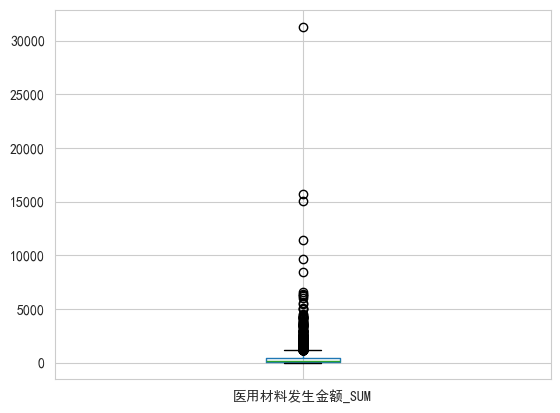

In [260]:
# 1，画箱线图
data.boxplot(column='医用材料发生金额_SUM')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.show()
# 发现多数的列呈右偏，故此处不用箱图进行异常值处理，采用缩尾处理

In [261]:
# 采用缩尾处理
for col in data.columns:
    if data[col].dtype is np.dtype('int64'):    #不对离散类型数据进行该处理
        continue
    df = data[col].tolist()
    def Winsorization_outliers(df):
        q1 = np.percentile(df,1)
        q3 = np.percentile(df,99)
        data.loc[data[col]>q3,col]=q3
        data.loc[data[col]<q1,col]=q1
    Winsorization_outliers(df=df)

In [262]:
# 删除每列只有一种值的列
for col in data.columns.tolist():
    count = len(data[col].unique())
    print(count)
    if count==1:
        data = data.drop(col,axis=1)
# 只有一列被删除

65
7
31
175
8
38
190
57
196
15414
15627
15305
15591
137
443
15595
15651
15510
15626
9
1
15293
15627
15614
15239
15588
6732
15586
4825
13383
8320
2844
124
3252
362
5420
262
4786
45
5
1
95
77
7603
1
752
16
486
8
6508
1
15182
120
1
15618
186
2127
5876
15261
15623
2144
121
1
2118
1
30
57
15677
11269
12181
1079
15676
2296
2
2
2
2


In [263]:
# 删除重复的行
data.drop_duplicates(inplace=True)

In [264]:
data

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,0,6,7,5.666667,3,2.166667,34,7,5.666667,3501.18,...,0.939194,4.262371e-03,0.050817,0.000000,0.007434,0.0,0,0,1,0
1,0,6,4,2.500000,2,1.333333,15,4,2.500000,2217.66,...,0.955626,2.981609e-03,0.030815,0.000000,0.013398,0.0,0,0,1,0
2,8,6,8,6.166667,3,2.166667,45,9,7.500000,3360.55,...,0.783610,3.321330e-04,0.000000,0.000000,0.195087,0.0,0,0,0,0
3,0,6,6,3.666667,2,1.833333,23,6,3.833333,3030.61,...,0.458649,1.843500e-04,0.000000,0.000000,0.541351,0.0,0,0,0,0
4,0,6,5,4.333333,1,1.000000,26,5,4.333333,2332.45,...,0.983726,3.163870e-04,0.000000,0.000000,0.016274,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,6,8,6.500000,3,3.000000,40,8,6.666667,2831.13,...,0.986674,5.260850e-04,0.000000,0.000000,0.013326,0.0,0,0,1,0
15996,0,6,8,6.833333,2,2.000000,42,9,7.000000,2369.03,...,0.927005,6.890000e-05,0.008665,0.000000,0.039553,0.0,1,0,0,0
15997,4,6,8,6.333333,2,2.000000,42,9,7.000000,5421.56,...,0.773433,6.738972e-03,0.002232,0.147661,0.223888,0.0,0,0,1,0
15998,0,6,5,3.333333,1,1.000000,20,5,3.333333,5270.74,...,0.967045,7.680000e-07,0.025627,0.000000,0.006425,0.0,0,0,0,0


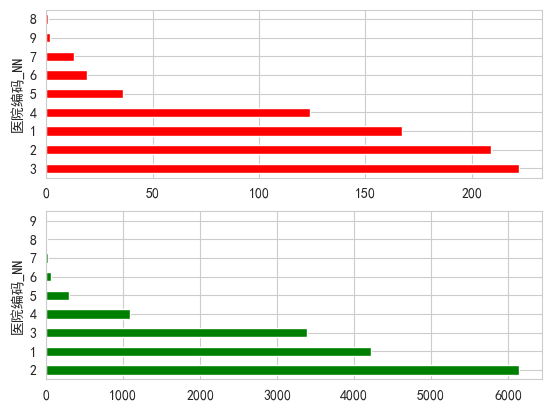

In [265]:
# 进行特征分析
col_1='医院编码_NN'
figure,ax = plt.subplots(2,1)
col_11_count = data.医院编码_NN[data['RES']==1].value_counts()
col_11_count.plot(ax=ax[0],kind='barh',color='red')
col_10_count = data.医院编码_NN[data['RES']==0].value_counts()
col_10_count.plot(kind='barh',label='0',ax=ax[1],color='green')
plt.show()
# 诈骗不同医院的就诊人数图
# 红色是欺诈（RES为1）

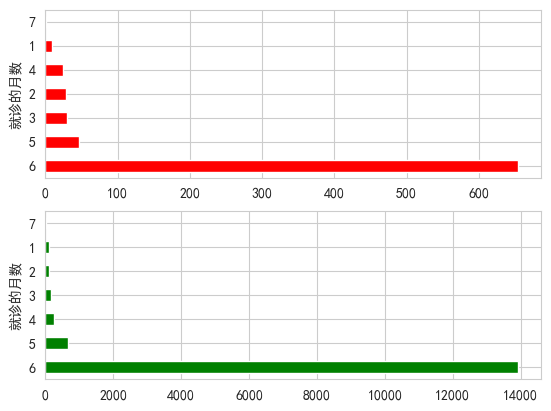

In [266]:
# 同理对就诊月数分析
col_2 = '就诊的月数'
_,ax = plt.subplots(2,1)
col_21_count = data.就诊的月数[data['RES']==1].value_counts()
col_21_count.plot(kind='barh',color='red',ax=ax[0])
col_20_count = data.就诊的月数[data['RES']==0].value_counts()
col_20_count.plot(kind='barh',color='green',ax=ax[1])
plt.show()

RES
0    15205
1      793
Name: count, dtype: int64


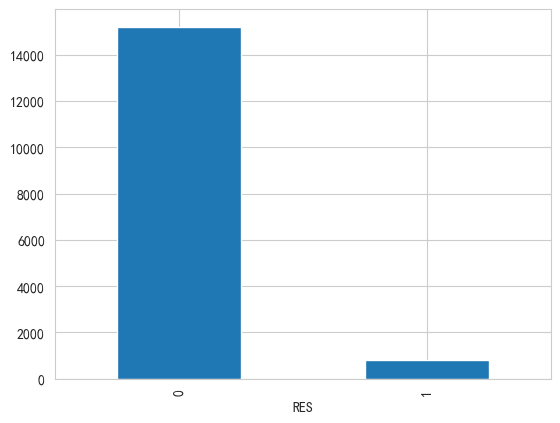

In [267]:
# 观察RES的分布情况
res_count = data["RES"].value_counts()
print(res_count)
res_count.plot(kind='bar')
plt.show()

In [268]:
## 使用筛选器法，去除高度相关的特征列（90%以上），使用皮尔逊系数
# 观察相关系数矩阵
target = 'RES'
feature = [x for x in data.columns if x not in target]
data_matrix = data[feature].corr()
plt.figure(figsize=(100, 100))
sns.heatmap(data_matrix, annot=True, cmap="YlGnBu")
plt.title("Correlation Heatmap")
plt.show()

D:\anaconda3\envs\py10\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
D:\anaconda3\envs\py10\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


In [269]:
data_matrix

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊天数_AVG,月就诊医院数_MAX,月就诊医院数_AVG,就诊次数_SUM,月就诊次数_MAX,月就诊次数_AVG,月统筹金额_MAX,...,出院诊断LENTH_MAX,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号
一天去两家医院的天数,1.000000,0.064557,0.472321,0.423914,0.468380,0.524468,0.641346,0.655709,0.555859,0.368918,...,0.100093,0.059427,-0.010920,-0.112283,-0.038541,0.003225,-0.042582,0.100974,-0.003004,-0.062619
就诊的月数,0.064557,1.000000,0.156867,0.154964,0.112397,0.103143,0.253809,0.131905,0.145706,0.042720,...,0.194487,0.194727,-0.013201,-0.078280,-0.044579,-0.064001,-0.009481,0.029023,0.006154,0.021309
月就诊天数_MAX,0.472321,0.156867,1.000000,0.945000,0.402466,0.429786,0.922372,0.955915,0.940435,0.511750,...,0.141875,-0.117424,0.035395,-0.164571,-0.023750,0.249556,-0.085274,0.135419,0.008534,-0.130993
月就诊天数_AVG,0.423914,0.154964,0.945000,1.000000,0.356933,0.411829,0.946284,0.887131,0.982722,0.481855,...,0.167742,-0.158437,0.026678,-0.179530,-0.024754,0.296493,-0.091404,0.137971,0.010907,-0.142443
月就诊医院数_MAX,0.468380,0.112397,0.402466,0.356933,1.000000,0.897902,0.427912,0.472335,0.432545,0.200378,...,0.133298,0.142573,-0.054039,-0.121945,-0.015824,-0.072147,-0.015599,0.086505,-0.008051,-0.139439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
治疗费用在总金额占比,0.003225,-0.064001,0.249556,0.296493,-0.072147,-0.062862,0.232376,0.198179,0.265984,0.451553,...,-0.046454,-0.856970,-0.074603,-0.154617,0.123921,1.000000,-0.049922,0.168811,0.003625,-0.054923
个人支付治疗费用占比,-0.042582,-0.009481,-0.085274,-0.091404,-0.015599,-0.023208,-0.086349,-0.080327,-0.091707,-0.017048,...,-0.035012,0.024202,0.016310,0.072298,0.076485,-0.049922,1.000000,-0.030736,-0.002284,0.075341
BZ_民政救助,0.100974,0.029023,0.135419,0.137971,0.086505,0.096494,0.144939,0.135328,0.148373,0.283552,...,0.004423,-0.083474,-0.026501,-0.141668,-0.035873,0.168811,-0.030736,1.000000,-0.009697,-0.066492
BZ_城乡优抚,-0.003004,0.006154,0.008534,0.010907,-0.008051,-0.010274,0.008982,0.005688,0.009243,0.005454,...,0.006708,-0.007086,-0.008515,0.012983,-0.005207,0.003625,-0.002284,-0.009697,1.000000,-0.007756


In [270]:
def remove_highly_correlated_columns(df, threshold=0.90):
    """
    删除高度相关的列
    """
    # 计算相关系数矩阵
    corr_matrix = df.corr().abs()

    # 找到高度相关的列
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # 删除高度相关的列
    df = df.drop(to_drop, axis=1)

    return df

In [271]:
data_del_high = remove_highly_correlated_columns(data[feature],threshold=0.9)

In [272]:
data_del_high= pd.concat([data_del_high,data[target]],axis=1)
data_del_high

,一天去两家医院的天数,就诊的月数,月就诊天数_MAX,月就诊医院数_MAX,月就诊医院数_AVG,月统筹金额_MAX,月药品金额_MAX,医院_就诊天数_MAX,医院_就诊天数_AVG,医院_统筹金_MAX,...,药品在总金额中的占比,个人支付的药品占比,检查总费用在总金额占比,个人支付检查费用占比,治疗费用在总金额占比,个人支付治疗费用占比,BZ_民政救助,BZ_城乡优抚,是否挂号,RES
0,0,6,7,3,2.166667,3501.18,3901.45,20,11.333333,7553.00,...,0.939194,4.262371e-03,0.050817,0.000000,0.007434,0.0,0,0,1,0
1,0,6,4,2,1.333333,2217.66,2449.13,13,7.500000,9500.07,...,0.955626,2.981609e-03,0.030815,0.000000,0.013398,0.0,0,0,1,0
2,8,6,8,3,2.166667,3360.55,3302.06,23,15.000000,9161.73,...,0.783610,3.321330e-04,0.000000,0.000000,0.195087,0.0,0,0,0,0
3,0,6,6,2,1.833333,3030.61,1500.12,17,11.500000,11622.17,...,0.458649,1.843500e-04,0.000000,0.000000,0.541351,0.0,0,0,0,0
4,0,6,5,1,1.000000,2332.45,2563.26,26,26.000000,13177.89,...,0.983726,3.163870e-04,0.000000,0.000000,0.016274,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0,6,8,3,3.000000,2831.13,3121.72,19,13.333333,7094.15,...,0.986674,5.260850e-04,0.000000,0.000000,0.013326,0.0,0,0,1,0
15996,0,6,8,2,2.000000,2369.03,2133.65,28,21.000000,9697.88,...,0.927005,6.890000e-05,0.008665,0.000000,0.039553,0.0,1,0,0,0
15997,4,6,8,2,2.000000,5421.56,4897.23,24,21.000000,12453.45,...,0.773433,6.738972e-03,0.002232,0.147661,0.223888,0.0,0,0,1,0
15998,0,6,5,1,1.000000,5270.74,6289.22,20,20.000000,22266.53,...,0.967045,7.680000e-07,0.025627,0.000000,0.006425,0.0,0,0,0,0


In [273]:
## 进行RFR和XGBoost加权排序

In [274]:
feature_ch = [x for x in data_del_high.columns if x not in target]
x = data_del_high[feature_ch].values
y = data_del_high[target].values

In [275]:
x

array([[ 0.,  6.,  7., ...,  0.,  0.,  1.],
       [ 0.,  6.,  4., ...,  0.,  0.,  1.],
       [ 8.,  6.,  8., ...,  0.,  0.,  0.],
       ...,
       [ 4.,  6.,  8., ...,  0.,  0.,  1.],
       [ 0.,  6.,  5., ...,  0.,  0.,  0.],
       [ 7.,  6., 13., ...,  0.,  0.,  0.]])

In [276]:
y

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [277]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 14)

In [278]:
pd.value_counts(y_train)

C:\Users\gaoxiangwei\AppData\Local\Temp\ipykernel_13104\3902155716.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_train)


0    10643
1      555
Name: count, dtype: int64

In [279]:
print(res_count)

RES
0    15205
1      793
Name: count, dtype: int64


In [280]:
pd.value_counts(y_test)

C:\Users\gaoxiangwei\AppData\Local\Temp\ipykernel_13104\3565148537.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_test)


0    4562
1     238
Name: count, dtype: int64

In [292]:
# 先进行RF
# 观察默认情况下的效果
# 选用precision进行评估，TP/(TP+FP)
# 并使用sample_weight处理类不平衡
rf0 = RandomForestClassifier(oob_score=True,
                             random_state=14)
sample_weight_rf00 = compute_sample_weight('balanced',
                                           y_train)
rf0.fit(x_train,
        y_train,
        sample_weight=sample_weight_rf00)
print (rf0.oob_score_)
sample_weight_rf01 = compute_sample_weight('balanced',
                                          y_test)
y_pred = rf0.predict(x_test)
print( "precision Score (Train): %f" % metrics.precision_score(y_true=y_test,
                                                               y_pred=y_pred))

0.9616002857653152
precision Score (Train): 0.861538


In [293]:
score = rf0.score(x_test, y_test)
print(score)

0.9602083333333333


In [297]:
## 进行参数优化
# 首先对n_estimators进行网格搜索
param_test1 = {'n_estimators':[x for x in range(300,400,10)]}
gsearch1 = GridSearchCV(estimator = RandomForestClassifier(oob_score=True, random_state=14,class_weight='balanced'),
                       param_grid = param_test1, scoring='precision',cv=5)
gsearch1.fit(x_train,y_train)
print( gsearch1.best_params_, gsearch1.best_score_)

{'n_estimators': 370} 0.8568957252424994


In [300]:
# 接着对决策树最大深度max_depth进行网格搜索
param_test2 = {'max_depth':[None,3,4,5]}
gsearch2 = GridSearchCV(estimator = RandomForestClassifier(n_estimators=370,oob_score=True,
                                                           random_state=14,class_weight='balanced'),
                        param_grid = param_test2, scoring='precision', cv=5)
gsearch2.fit(x_train,y_train)
print( gsearch2.best_params_, gsearch2.best_score_)

{'max_depth': None} 0.8568957252424994


In [304]:
rf1 = RandomForestClassifier(n_estimators= 370,oob_score=True,
                             random_state=14)
sample_weight_rf1=compute_sample_weight('balanced',
                                        y_train)
rf1.fit(x_train,y_train,sample_weight=sample_weight_rf1)
print( rf1.oob_score_)
y_pred= rf1.predict(x_test)
print( "Precision Score (Train): %f" % metrics.precision_score(y_test, y_pred))

0.9616002857653152
Precision Score (Train): 0.883333


In [305]:
# 下面再对内部节点再划分所需最小样本数min_samples_split和叶子节点最少样本数min_samples_leaf一起调参
param_test3 = {'min_samples_split':[2,3,4,], 'min_samples_leaf':[1,3,4,]}
gsearch3 = GridSearchCV(estimator = RandomForestClassifier(n_estimators= 370,
                                                           oob_score=True,
                                                           random_state=14,
                                                           class_weight='balanced'),
                        param_grid = param_test3,
                        scoring='precision',
                        cv=5)
gsearch3.fit(x_train,y_train)
print( gsearch3.best_params_, gsearch3.best_score_)

{'min_samples_leaf': 1, 'min_samples_split': 2} 0.8568957252424994


In [307]:
# 用搜索到的最佳参数，再看看最终的模型拟合,观察到精确率有所提高
rf2 = RandomForestClassifier(n_estimators= 370,min_samples_split=2,
                                min_samples_leaf=1,oob_score=True, random_state=14)
sample_weight_rf20 = compute_sample_weight('balanced',
                                           y_train)
rf2.fit(x_train,y_train,sample_weight=sample_weight_rf20)
print (rf2.oob_score_)
sample_weight_rf2 = compute_sample_weight('balanced',
                                          y_test)
y_pred2=rf2.predict(x_test)
print( "precision Score (Train): %f" % metrics.precision_score(y_test, y_pred2))

0.9616002857653152
precision Score (Train): 0.883333


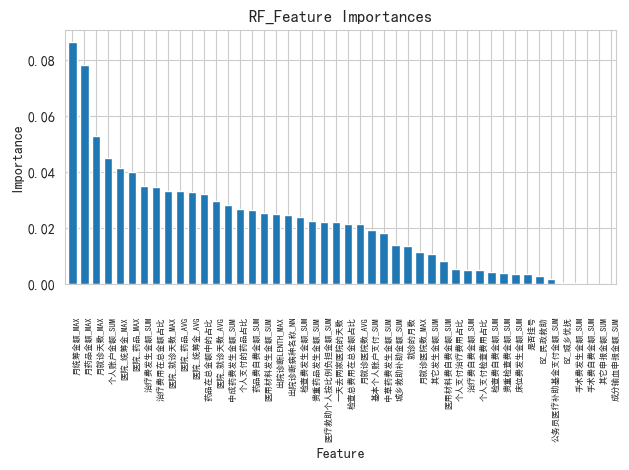

In [308]:
# 获取特征得分
rf2.fit(x,y)
_, ax = plt.subplots()
rf_importances = rf2.feature_importances_
feature_names = data_del_high.columns
sorted_indices = np.argsort(rf_importances)[::-1]
sorted_feature_names = [feature_names[i] for i in sorted_indices]
sorted_importances = [rf_importances[i] for i in sorted_indices]

ax.bar(range(len(sorted_importances)),sorted_importances,align='center',width=0.7)
ax.set_title("RF_Feature Importances")
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
ax.set_xticks(range(len(sorted_feature_names)))
ax.set_xticklabels(sorted_feature_names, rotation=90, ha='right',rotation_mode='anchor',fontsize=6)
ax.tick_params(axis='x', pad=20)
ax.set_xlim(-0.6, len(sorted_feature_names) - 0.6)
plt.tight_layout()
plt.show()

In [314]:
importance_rf_df = pd.DataFrame({
    'Feature': sorted_feature_names,
    'Importance': sorted_importances
})
y_pre = rf2.predict(x_test)
print( "f1 Score (All): %f" % metrics.precision_score(y_test, y_pre))
importance_rf_df

f1 Score (All): 1.000000


,Feature,Importance
0,月统筹金额_MAX,0.086250
1,月药品金额_MAX,0.078300
2,月就诊天数_MAX,0.052882
3,个人账户金额_SUM,0.045193
4,医院_统筹金_MAX,0.041586
5,医院_药品_MAX,0.040102
6,治疗费发生金额_SUM,0.035142
7,治疗费用在总金额占比,0.034667
8,医院_就诊天数_MAX,0.033340
9,医院_药品_AVG,0.033129


[[4531   31]
 [ 167   71]]


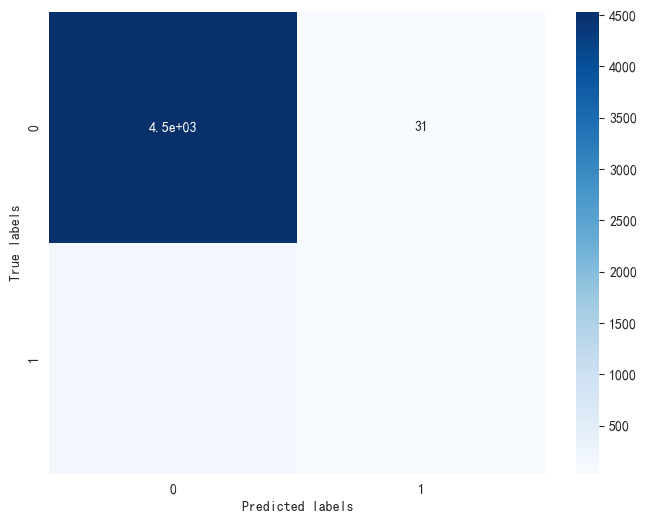

	预测结果评价报表：
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      4562
           1       0.70      0.30      0.42       238

    accuracy                           0.96      4800
   macro avg       0.83      0.65      0.70      4800
weighted avg       0.95      0.96      0.95      4800



In [315]:
xgb0 = XGBClassifier()
xgb0.fit(x_train,y_train)
test_predict = xgb0.predict(x_test)
confusion_matrix_result = metrics.confusion_matrix(y_pred=test_predict,y_true=y_test)
print(confusion_matrix_result)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print("\t预测结果评价报表：\n", metrics.classification_report(y_true=y_test,y_pred=test_predict))

In [316]:
# n_estimators调参
param_xgb_test1 = {'n_estimators':[i for i in range(20,90,10)]
                   }
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 max_depth=5,
                                                 max_delta_step=1,
                                                 min_child_weight=1,
                                                 gamma=0,
                                                 subsample=0.8,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test1,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('max_depth_min_child_weight')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

max_depth_min_child_weight
gsearch1.best_params_ {'n_estimators': 70}
gsearch1.best_score_ 0.792740931147986


In [318]:
# max_depth和min_child_weight参数调优
# max_depth和min_child_weight参数对最终结果有很大的影响。max_depth通常在3-10之间，min_child_weight。采用grid search，我们先大
# 范围地粗略参数，然后再小范围的微调。
param_xgb_test2 = {'max_depth':[i for i in range(7,8,1)],
                   'min_child_weight':[i for i in range(0,3,1)]
                   }
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=70,
                                                 max_delta_step=1,
                                                 gamma=0,
                                                 subsample=0.8,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test2,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('max_depth_min_child_weight')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

max_depth_min_child_weight
gsearch1.best_params_ {'max_depth': 7, 'min_child_weight': 0}
gsearch1.best_score_ 0.7947969329288844


In [322]:
# gamma参数调优
param_xgb_test3 = {'gamma':[i/10.0 for i in range(0,5,1)]}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=70,
                                                 max_depth=7,
                                                 max_delta_step=1,
                                                 min_child_weight=0,
                                                 subsample=0.8,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test3,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('gamma')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

gamma
gsearch1.best_params_ {'gamma': 0.0}
gsearch1.best_score_ 0.7947969329288844


In [323]:
# 调整subsample参数
param_xgb_test4 = {'subsample':[i/10.0 for i in range(0,10)],
                   }
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=70,
                                                 max_depth=7,
                                                 max_delta_step=1,
                                                 min_child_weight=0,
                                                 gamma=0,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test4,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('subsample')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

subsample
gsearch1.best_params_ {'subsample': 0.1}
gsearch1.best_score_ 0.8367096495200608


In [324]:
param_xgb_test5 = {'max_delta_step':[x for x in range(0,4,1)]}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=70,
                                                 max_depth=7,
                                                 min_child_weight=0,
                                                 subsample=0.1,
                                                 gamma=0,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test5,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('max_delta_step')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

max_delta_step
gsearch1.best_params_ {'max_delta_step': 1}
gsearch1.best_score_ 0.8367096495200608


In [325]:
#正则化参数调优reg_alpha
param_xgb_test6 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}
gsearch = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                 n_estimators=70,
                                                 max_depth=7,
                                                 min_child_weight=0,
                                                 max_delta_step=1,
                                                 subsample=0.1,
                                                 gamma=0,
                                                 objective= 'binary:logistic',
                                                 nthread=4,
                                                 seed=14),
                       param_grid = param_xgb_test6,scoring='precision',n_jobs=4,cv=5)
gsearch.fit(x_train,y_train)
print('reg_alpha')
print('gsearch1.best_params_', gsearch.best_params_)
print('gsearch1.best_score_', gsearch.best_score_)

reg_alpha
gsearch1.best_params_ {'reg_alpha': 1e-05}
gsearch1.best_score_ 0.8367096495200608


The precision of the XGBClassifier is: 0.8823529411764706
[[4552   10]
 [ 163   75]]


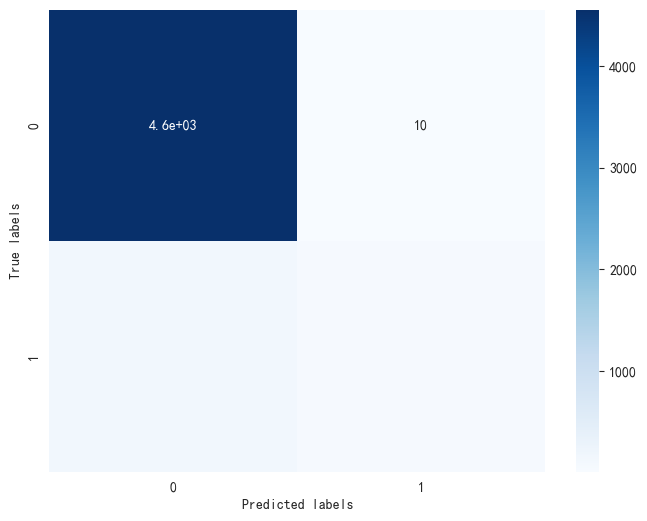

	预测结果评价报表：
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      4562
           1       0.88      0.32      0.46       238

    accuracy                           0.96      4800
   macro avg       0.92      0.66      0.72      4800
weighted avg       0.96      0.96      0.96      4800



In [326]:
xgb1=XGBClassifier(learning_rate =0.1,
                   n_estimators=70,
                   max_depth=7,
                   min_child_weight=0,
                   reg_alpha=1e-05,
                   max_delta_step=1,
                   subsample=0.1,
                   objective= 'binary:logistic',
                   nthread=4,
                   seed=14)
xgb1.fit(x,y)
test_predict1 = xgb1.predict(x_test)
print('The precision of the XGBClassifier is:',metrics.precision_score(y_true=y_test,y_pred=test_predict1))
confusion_matrix_result1 = metrics.confusion_matrix(y_pred=test_predict1,y_true=y_test)
print(confusion_matrix_result1)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result1, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
print("\t预测结果评价报表：\n", metrics.classification_report(y_test,test_predict1))

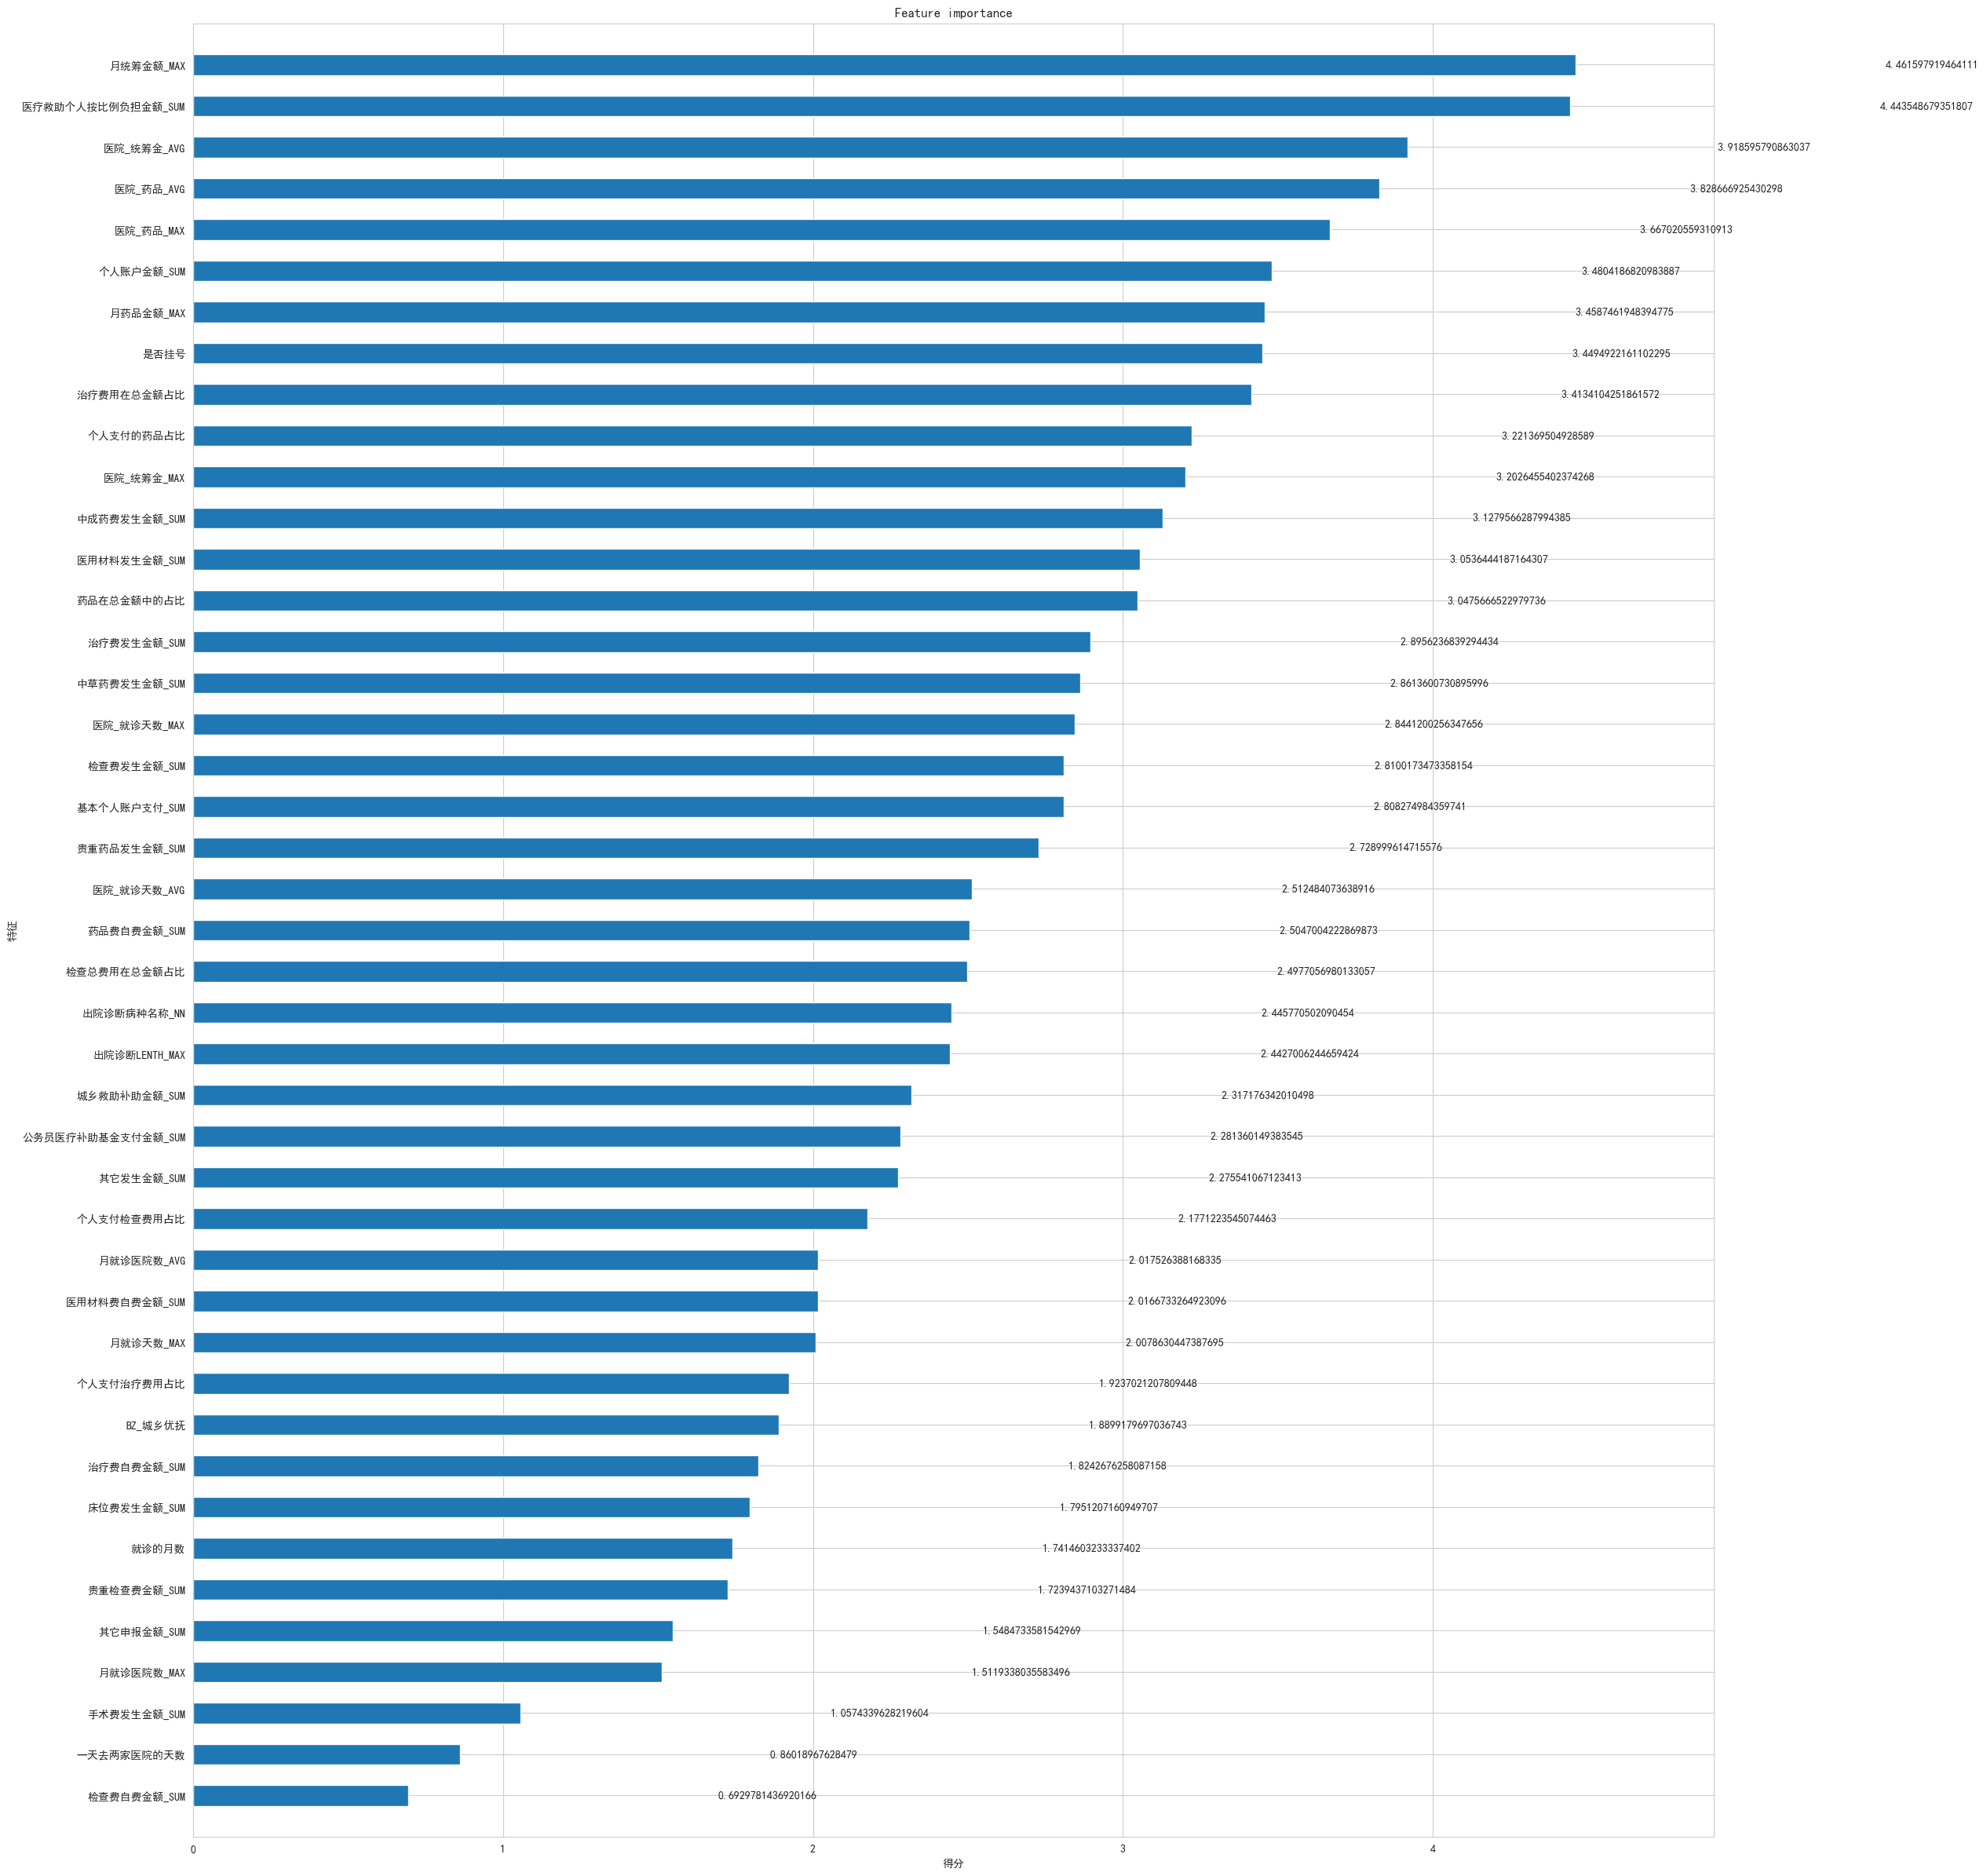

In [327]:
xgb1.get_booster().feature_names = list(data_del_high.columns)[:-1]
_,ax = plt.subplots(figsize=(25,30))
plot_importance(xgb1,importance_type='gain',ax=ax,height=0.5,xlabel='得分',ylabel='特征')
plt.show()

In [328]:
# 获取xgb的特征得分并进行minmax变化
importance_xgb = xgb1.get_booster().get_score(importance_type='gain')
importance_xgb_df = pd.DataFrame(list(importance_xgb.items()))
importance_xgb_df.columns=['Feature','Importance']
mm_scaler = MinMaxScaler()
importance_xgb_df['Importance']=mm_scaler.fit_transform(np.array(importance_xgb_df['Importance']).reshape(-1,1))
importance_xgb_df.sort_values(by='Importance',inplace=True,ascending=False)

In [329]:
importance_xgb_df

,Feature,Importance
5,月统筹金额_MAX,1.000000
29,医疗救助个人按比例负担金额_SUM,0.995211
10,医院_统筹金_AVG,0.855915
12,医院_药品_AVG,0.832052
11,医院_药品_MAX,0.789160
13,个人账户金额_SUM,0.739645
6,月药品金额_MAX,0.733894
42,是否挂号,0.731439
39,治疗费用在总金额占比,0.721864
36,个人支付的药品占比,0.670906


In [330]:
# 对rf的特征得分进行minmax变化
importance_rf_df["Importance"]=mm_scaler.fit_transform(np.array(importance_rf_df['Importance']).reshape(-1,1))

In [331]:
# 合并两个dataframe
importance_all = pd.merge(importance_rf_df,importance_xgb_df,how='outer',on='Feature')
importance_all=importance_all.fillna(0)
importance_all

,Feature,Importance_x,Importance_y
0,月统筹金额_MAX,1.000000,1.000000
1,月药品金额_MAX,0.907684,0.733894
2,月就诊天数_MAX,0.612546,0.348904
3,个人账户金额_SUM,0.523267,0.739645
4,医院_统筹金_MAX,0.481381,0.665938
5,医院_药品_MAX,0.464150,0.789160
6,治疗费发生金额_SUM,0.406555,0.584470
7,治疗费用在总金额占比,0.401047,0.721864
8,医院_就诊天数_MAX,0.385636,0.570804
9,医院_药品_AVG,0.383187,0.832052


In [332]:
# 将得分相加
importance_all['Importance']=importance_all['Importance_x']+importance_all['Importance_y']
importance_all

,Feature,Importance_x,Importance_y,Importance
0,月统筹金额_MAX,1.000000,1.000000,2.000000
1,月药品金额_MAX,0.907684,0.733894,1.641578
2,月就诊天数_MAX,0.612546,0.348904,0.961450
3,个人账户金额_SUM,0.523267,0.739645,1.262912
4,医院_统筹金_MAX,0.481381,0.665938,1.147319
5,医院_药品_MAX,0.464150,0.789160,1.253309
6,治疗费发生金额_SUM,0.406555,0.584470,0.991025
7,治疗费用在总金额占比,0.401047,0.721864,1.122912
8,医院_就诊天数_MAX,0.385636,0.570804,0.956439
9,医院_药品_AVG,0.383187,0.832052,1.215239


In [333]:
# 按照Importance进行排序
importance_all.sort_values(by='Importance',inplace=True,ascending=False)
importance_all

,Feature,Importance_x,Importance_y,Importance
0,月统筹金额_MAX,1.000000,1.000000,2.000000
1,月药品金额_MAX,0.907684,0.733894,1.641578
3,个人账户金额_SUM,0.523267,0.739645,1.262912
5,医院_药品_MAX,0.464150,0.789160,1.253309
21,医疗救助个人按比例负担金额_SUM,0.257569,0.995211,1.252780
10,医院_统筹金_AVG,0.380967,0.855915,1.236882
9,医院_药品_AVG,0.383187,0.832052,1.215239
4,医院_统筹金_MAX,0.481381,0.665938,1.147319
7,治疗费用在总金额占比,0.401047,0.721864,1.122912
11,药品在总金额中的占比,0.373264,0.624788,0.998052


In [334]:
# 删除合并前的两列得分
imp_all=importance_all.iloc[0:30,:]
imp_all=imp_all.drop(['Importance_x','Importance_y'],axis=1)
imp_all=imp_all.reset_index(drop=True)
imp_all

,Feature,Importance
0,月统筹金额_MAX,2.000000
1,月药品金额_MAX,1.641578
2,个人账户金额_SUM,1.262912
3,医院_药品_MAX,1.253309
4,医疗救助个人按比例负担金额_SUM,1.252780
5,医院_统筹金_AVG,1.236882
6,医院_药品_AVG,1.215239
7,医院_统筹金_MAX,1.147319
8,治疗费用在总金额占比,1.122912
9,药品在总金额中的占比,0.998052


In [ ]:
## 对选择出来的30个特征使用relief算法

In [338]:
# 数据构建
data1 = data_del_high[list(imp_all['Feature'])]
data1=pd.concat([data1,data_del_high['RES']],axis=1)
data1

,月统筹金额_MAX,月药品金额_MAX,个人账户金额_SUM,医院_药品_MAX,医疗救助个人按比例负担金额_SUM,医院_统筹金_AVG,医院_药品_AVG,医院_统筹金_MAX,治疗费用在总金额占比,药品在总金额中的占比,...,基本个人账户支付_SUM,是否挂号,出院诊断LENTH_MAX,出院诊断病种名称_NN,检查总费用在总金额占比,月就诊医院数_AVG,城乡救助补助金额_SUM,其它发生金额_SUM,个人支付检查费用占比,RES
0,3501.18,3901.45,1970.99,8522.57,0.0,5082.586667,5390.583333,7553.00,0.007434,0.939194,...,228.80,1,29.0,4,0.050817,2.166667,0.00,34.0,0.000000,0
1,2217.66,2449.13,1371.57,10309.64,0.0,4912.075000,5349.460000,9500.07,0.013398,0.955626,...,199.50,1,20.0,3,0.030815,1.333333,0.00,0.0,0.000000,0
2,3360.55,3302.06,2637.20,10760.51,0.0,5166.106667,4737.056667,9161.73,0.195087,0.783610,...,234.00,0,29.0,4,0.000000,2.166667,0.00,11.2,0.000000,0
3,3030.61,1500.12,1373.06,5504.60,0.0,6173.160000,3146.190000,11622.17,0.541351,0.458649,...,73.34,0,16.0,5,0.000000,1.833333,0.00,0.0,0.000000,0
4,2332.45,2563.26,1569.65,14507.54,0.0,13177.890000,14507.540000,13177.89,0.016274,0.983726,...,64.00,0,33.0,2,0.000000,1.000000,0.00,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,2831.13,3121.72,1496.13,7808.41,0.0,4279.026667,4714.070000,7094.15,0.013326,0.986674,...,0.00,1,28.0,8,0.000000,3.000000,0.00,0.0,0.000000,0
15996,2369.03,2133.65,750.84,8650.76,0.0,6210.675000,5589.690000,9697.88,0.039553,0.927005,...,145.06,0,25.0,5,0.008665,2.000000,1112.51,8.4,0.000000,0
15997,5421.56,4897.23,3025.40,12665.65,0.0,11927.060000,10394.760000,12453.45,0.223888,0.773433,...,196.00,1,30.0,4,0.002232,2.000000,0.00,12.0,0.147661,0
15998,5270.74,6289.22,4658.08,26037.31,0.0,22266.530000,26037.310000,22266.53,0.006425,0.967045,...,176.44,0,5.0,2,0.025627,1.000000,0.00,0.0,0.000000,0


In [359]:
data1.to_csv("./data1.csv")

In [354]:
class Filter:
    def __init__(self, data_df, sample_rate, t, k):
        """
        #
        :param data_df: 数据框（字段为特征，行为样本）
        :param sample_rate: 抽样比例
        :param t: 统计量分量阈值
        :param k: 选取的特征的个数
        """
        self.__data = data_df
        self.__feature = data_df.columns
        self.__sample_num = int(round(len(data_df) * sample_rate))#round函数：四舍五入
        self.__t = t
        self.__k = k

    def get_data(self):
        new_data = pd.DataFrame()#建立一个空二维表
        for one in self.__feature[:-1]:#遍历循环每个特征
            col = self.__data[one]#读取全部样本中其中一个特征
            # 判断读取到的特征是否全为数值类，如果字符串中全为数字  ，则不作改变写进新的二维表new_data里面，否则处理成数值类型写进二维表
            if (str(list(col)[0]).split(".")[0]).isdigit() or str(list(col)[0]).isdigit()\
            or (str(list(col)[0]).split('-')[-1]).split(".")[-1].isdigit():#isdigit函数：如果是字符串包含数字返回ture,否则返回false
                new_data[one] = self.__data[one]
            else:
                keys = list(set(list(col)))#set函数：删除重复值,得到一个特征的类别，如色泽：青绿、浅白、乌黑
                values = list(range(len(keys)))#遍历循环len（keys)，色泽特征为例，三个特征类别，则得到三个数0、1、2
                new = dict(zip(keys, values))#dict函数就是创建一个字典，zip函数矩阵中的元素对应打包成一个元组列表
                new_data[one] = self.__data[one].map(new)#map函数：将new: {'青绿': 0, '浅白': 1, '乌黑': 2}在col列表里做一个映射
        new_data[self.__feature[-1]] = self.__data[self.__feature[-1]]#瓜的类别属性不做改变
        return new_data

    def get_neighbors(self, row):
        df = self.get_data()
        #row是一行一行（一个一个）样本
        row_type = row[df.columns[-1]]#矩阵最后一列：瓜的类别，如好瓜、坏瓜、模糊
        #下面进行分类，与读取到的样本类型相同的分为  “同类”，不相同的分为 “异类”，储存在两个数据集中
        right_df = df[df[df.columns[-1]] == row_type].drop(columns=[df.columns[-1]])#筛选出数据集类别与读取样本同类的样本，删除数据集最后一列
        #将删除后的数据集储存在right_df中，原数据集df保持不变。
        wrong_df = df[df[df.columns[-1]] != row_type].drop(columns=[df.columns[-1]])#异类样本数据集
        aim = row.drop(df.columns[-1])#删除类别特征
        f = lambda x: eulidSim(np.mat(x.values), np.mat(aim.values))#lambda函数：定义一个隐函数，  mat函数：转换为矩阵，方便线性代数的
        # 操作
        #eulidsim函数是自己定义的一个计算距离的函数
        right_sim = right_df.apply(f, axis=1)#apply函数：就是将right_df里面的每个变量，axis=1按行的顺序计算，
        #apply函数解释链接： https://www.cnblogs.com/xiaodongsuibi/p/8927688.html
        right_sim_two = right_sim.drop(right_sim.idxmin())#idxmin()函数：获取某行最小的序列号，里面删除了读取样本本身的那个数据
        #之所以在同类中删除距离最小的那个数据，是因为在原数据集中，包括了本身的那个数据
        wrong_sim = wrong_df.apply(f, axis=1)
        return right_sim_two.idxmin(), wrong_sim.idxmin()

    def get_weight(self, feature, index, NearHit, NearMiss):
        data = self.__data.drop(self.__feature[-1], axis=1)#西瓜数据集
        row = data.iloc[index]#选取到的数据样本，命名为样本X
        nearhit = data.iloc[NearHit]#猜对近邻数据样本
        nearmiss = data.iloc[NearMiss]#猜错近邻数据样本
        #将特征的数据类型分类，分类连续型和离散型，不同类型的数据，用不同的方法计算特征距离
        if (str(row[feature]).split(".")[0]).isdigit() or str(row[feature]).isdigit() \
                or (str(row[feature]).split('-')[-1]).split(".")[-1].isdigit():
            #连续型特征距离计算方式：
            max_feature = data[feature].max()#连续型数据特征的最大值
            min_feature = data[feature].min()#连续型数据特征的最小值
            #公式原理：如果两个特征值差距越小，则距离越近，反之，则距离越远，加一个分母是为了归一化
            right = pow(round(abs(row[feature] - nearhit[feature]) / (max_feature - min_feature), 2), 2)#猜对近邻特征权重
            wrong = pow(round(abs(row[feature] - nearmiss[feature]) / (max_feature - min_feature), 2), 2)#猜错近邻特征权重
        else:
            # 离散型特征距离计算方式：
            right = 0 if row[feature] == nearhit[feature] else 1#如果猜对近邻特征与样本X一样。则返回0，不一样返回1
            wrong = 0 if row[feature] == nearmiss[feature] else 1#如果猜错近邻特征与样本X一样。则返回0，不一样返回1
        w = wrong - right#right越小，说明两个同类样本的特征越相似，反之，则同类样本差距越大。
                         #wrong越小，说明两个异类样本的特征越相似，反之，则异类样本差距越大。
        #w越大，说明wrong越大，ringt越小，则表示同类的样本间，该特征的数值差距小，不同类的差距大，说明以该特征区分不同类别，比较容易。
        return w

    def relief(self):
        sample = self.get_data()
        m, n = np.shape(self.__data)  # m为行数，n为列数
        score = []
        sample_index = random.sample(range(0, m), self.__sample_num)#random.sample函数：从指定序列中随机获取指定长度的片断。sample函数不会修改原有序列。
        print ('采样样本索引为 %s ' % sample_index)
        num = 1
        for i in sample_index:    # 采样次数
            one_score = dict()#创建一个字典
            row = sample.iloc[i]
            NearHit, NearMiss = self.get_neighbors(row)
            print ('第 %s 次采样，样本index为 %s，其NearHit行索引为 %s ，NearMiss行索引为 %s' % (num, i, NearHit, NearMiss))
            for f in self.__feature[0:-1]:
                w = self.get_weight(f, i, NearHit, NearMiss)
                one_score[f] = w
                print( '特征 %s 的权重为 %s.' % (f, w))
            score.append(one_score)
            num += 1
        f_w = pd.DataFrame(score)#将字典的格式换成表格
        print ('采样各样本特征权重如下：')
        #print (f_w)
        print ('平均特征权重如下：')
        print (f_w.mean())
        return f_w.mean()

    def get_final(self):
        f_w = pd.DataFrame(self.relief(), columns=['weight'])
        print("f_w:",f_w)
        final_feature_t = f_w[f_w['weight'] > self.__t]#设置阈值，将大于阈值的属性筛选出来
        print ("final_feature_t:",final_feature_t)
        final_feature_k = f_w.sort_values('weight').head(self.__k)#sort_values函数：排序函数，https://blog.csdn.net/qq_24753293/article/details/80692679
        print ("final_feature_k:",final_feature_k)
        return final_feature_t, final_feature_k

def eulidSim(vecA, vecB):
    return la.norm(vecA - vecB)


In [358]:
f=Filter(data1,0.005,0,8)
f.relief()
f.get_final()

采样样本索引为 [14640, 11318, 1628, 9143, 15260, 10074, 4805, 6664, 4223, 13981, 853, 11781, 414, 11474, 10757, 15547, 11512, 6501, 14690, 15207, 2323, 3677, 4698, 3296, 13554, 9075, 3411, 4266, 5641, 10580, 14756, 3610, 4539, 7599, 14026, 6046, 10143, 6545, 15120, 11642, 2469, 4907, 14929, 9316, 2934, 12807, 5114, 15376, 11860, 11519, 14139, 6222, 4464, 571, 12736, 10584, 15802, 2180, 10912, 4371, 2307, 1238, 14058, 36, 12476, 3359, 14822, 3944, 5582, 14854, 7799, 8367, 8853, 3416, 15625, 637, 419, 15883, 6823, 910] 
第 1 次采样，样本index为 14640，其NearHit行索引为 9153 ，NearMiss行索引为 5304
特征 月统筹金额_MAX 的权重为 -0.014700000000000001.
特征 月药品金额_MAX 的权重为 -0.0016999999999999993.
特征 个人账户金额_SUM 的权重为 0.0.
特征 医院_药品_MAX 的权重为 -0.016000000000000004.
特征 医疗救助个人按比例负担金额_SUM 的权重为 0.0.
特征 医院_统筹金_AVG 的权重为 -0.0020999999999999977.
特征 医院_药品_AVG 的权重为 -0.041999999999999996.
特征 医院_统筹金_MAX 的权重为 -0.0014999999999999996.
特征 治疗费用在总金额占比 的权重为 -0.1271.
特征 药品在总金额中的占比 的权重为 -0.0561.
特征 治疗费发生金额_SUM 的权重为 -0.0065.
特征 个人支付的药品占比 的权重为 0.019600000000

(                     weight
 月统筹金额_MAX          0.001455
 医疗救助个人按比例负担金额_SUM  0.025000
 医院_就诊天数_AVG        0.009526
 中草药费发生金额_SUM       0.009276
 药品费自费金额_SUM        0.021071
 出院诊断LENTH_MAX      0.008337
 出院诊断病种名称_NN        0.004215
 检查总费用在总金额占比        0.001724
 月就诊医院数_AVG         0.043198
 城乡救助补助金额_SUM       0.029810
 其它发生金额_SUM         0.022774,
                 weight
 是否挂号         -0.137500
 中成药费发生金额_SUM -0.050069
 个人账户金额_SUM   -0.031085
 个人支付检查费用占比   -0.029656
 基本个人账户支付_SUM -0.020234
 贵重药品发生金额_SUM -0.014746
 治疗费用在总金额占比   -0.011583
 药品在总金额中的占比   -0.010545)